# Run two layer model with AR6 forcing

- Use the provided historical forcing and uncertianty from 040, but with correlated parameters from 057. This stands separate from 058.

In [1]:
import fair
import json
import sys
import os
import random
import numpy as np
import scipy.stats as st       # v1.4+ needed
import matplotlib.pyplot as pl
import pandas as pd
from multiprocessing import Pool

from ar6.utils.h5 import *
from ar6.forcing.aerosol import aerocom_n, ghan

from netCDF4 import Dataset
from tqdm import tqdm_notebook
from scipy.interpolate import interp1d
from fair.constants import molwt
from fair.constants.general import EARTH_RADIUS
from fair.ancil import natural, cmip6_volcanic, cmip6_solar

import openscm_units.unit_registry as ur
from scmdata import ScmRun, run_append

from openscm_twolayermodel import TwoLayerModel
import tqdm.autonotebook as tqdman
from openscm_twolayermodel.constants import DENSITY_WATER, HEAT_CAPACITY_WATER

from tqdm.notebook import tqdm

<IPython.core.display.Javascript object>

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/base.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


In [2]:
fair.__version__

'1.6.2'

## Ensemble generation

We want to ensure reproducible results that don't change when this script is re-run. Grab list of pre-generated random seeds.

In [3]:
with open('../data_input/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

In [4]:
NINETY_TO_ONESIGMA = st.norm.ppf(0.95)

In [5]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), 'Variable'], emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
df_emissions.rename(
    columns={
        'Emissions|BC': 'BC',
        'Emissions|OC': 'OC',
        'Emissions|Sulfur': 'SO2',
        'Emissions|NOx': 'NOx',
        'Emissions|NH3': 'NH3',
        'Emissions|VOC': 'VOC',
        'Emissions|CO': 'CO'
    }, inplace=True
)
# only keep cols we want
emissions = df_emissions[['SO2', 'BC', 'OC', 'NH3', 'NOx', 'VOC', 'CO']]
emissions.index = emissions.index.astype('int')
emissions.index.name='year'
emissions.columns.name=None

emissions_ceds_update = emissions.copy()

emissions_old = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), 'Variable'], emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
for species in ['BC', 'OC', 'Sulfur', 'NOx', 'NH3', 'VOC', 'CO']:
    df_emissions[species] = df_emissions['Emissions|{}|MAGICC Fossil and Industrial'.format(species)] + df_emissions['Emissions|{}|MAGICC AFOLU|Agriculture'.format(species)]
df_emissions.rename(columns = {'Sulfur': 'SO2'}, inplace=True)
df_emissions.drop(columns=[
        'Emissions|BC|MAGICC Fossil and Industrial',
        'Emissions|OC|MAGICC Fossil and Industrial',
        'Emissions|Sulfur|MAGICC Fossil and Industrial',
        'Emissions|NOx|MAGICC Fossil and Industrial',
        'Emissions|NH3|MAGICC Fossil and Industrial',
        'Emissions|VOC|MAGICC Fossil and Industrial',
        'Emissions|CO|MAGICC Fossil and Industrial',
        'Emissions|BC|MAGICC AFOLU|Agriculture',
        'Emissions|OC|MAGICC AFOLU|Agriculture',
        'Emissions|Sulfur|MAGICC AFOLU|Agriculture',
        'Emissions|NOx|MAGICC AFOLU|Agriculture',
        'Emissions|NH3|MAGICC AFOLU|Agriculture',
        'Emissions|VOC|MAGICC AFOLU|Agriculture',
        'Emissions|CO|MAGICC AFOLU|Agriculture',
    ],
    inplace=True
)
df_emissions.index = emissions.index.astype('int')
df_emissions.index.name='year'
df_emissions.columns.name=None

global_total = {}
for species in ['BC', 'OC', 'SO2', 'NH3', 'NOx', 'NMVOC', 'CO']:
    df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/{}_global_CEDS_emissions_by_sector_2020_09_11.csv'.format(species))
    global_total[species] = df.sum(axis=0).values[3:].astype(float) / 1000 # yes could get openscm on this
    #unit = df.units[0]
    #print(unit)
global_total['VOC'] = global_total.pop('NMVOC')
new_ceds = pd.DataFrame(global_total)
new_ceds.index = np.arange(1750,2020)
new_ceds.index = new_ceds.index.astype('int')
new_ceds.index.name='year'
new_ceds.columns.name=None
emissions_ceds_update = new_ceds.loc[1750:2020] + emissions - df_emissions
emissions_ceds_update.drop(index=range(2020,2101), inplace=True)
emissions_ceds_update

,BC,CO,NH3,NOx,OC,SO2,VOC
year,,,,,,,
1750,2.097336,348.420476,6.683996,12.730074,15.447054,2.312083,60.599376
1751,2.072491,343.819148,6.615537,12.587160,15.188102,2.281498,59.667759
1752,2.063877,341.701465,6.573965,12.589121,15.033861,2.270899,59.213713
1753,2.071515,343.567551,6.635011,12.534665,15.181930,2.284976,59.610148
1754,2.098914,349.707369,6.767852,12.631676,15.558158,2.336934,60.855827
...,...,...,...,...,...,...,...
2015,7.992567,894.144647,62.462922,138.718989,30.046634,91.076152,213.006570
2016,7.918346,874.700320,63.054904,137.128483,30.086767,87.215738,211.778440
2017,7.886938,867.879243,63.739495,137.159668,30.057079,84.269791,211.717165


## Climate model parameters

### load unconstrained

In [6]:
# ozone
ozone_feedback = np.load('../data_input_large/fair-samples/ozone_feedback_unconstrained.npy')
beta_ch4 = np.load('../data_input_large/fair-samples/beta_ch4_unconstrained.npy')
beta_n2o = np.load('../data_input_large/fair-samples/beta_n2o_unconstrained.npy')
beta_ods = np.load('../data_input_large/fair-samples/beta_ods_unconstrained.npy')
beta_co = np.load('../data_input_large/fair-samples/beta_co_unconstrained.npy')
beta_voc = np.load('../data_input_large/fair-samples/beta_voc_unconstrained.npy')
beta_nox = np.load('../data_input_large/fair-samples/beta_nox_unconstrained.npy')

# aerosol
beta_so2 = np.load('../data_input_large/fair-samples/beta_so2_unconstrained.npy')
beta_bc = np.load('../data_input_large/fair-samples/beta_bc_unconstrained.npy')
beta_oc = np.load('../data_input_large/fair-samples/beta_oc_unconstrained.npy')
beta_nh3 = np.load('../data_input_large/fair-samples/beta_nh3_unconstrained.npy')
beta = np.load('../data_input_large/fair-samples/beta_unconstrained.npy')
aci_coeffs = np.load('../data_input_large/fair-samples/aci_coeffs.npy')

# forcing
scale_normals = np.load('../data_input_large/fair-samples/scale_normals.npy')
trend_solar = np.load('../data_input_large/fair-samples/scale_trend_solar.npy')

# climate response
geoff_sample_df = pd.read_csv('../data_output_large/geoff_sample.csv', index_col=0)
f2x = np.load('../data_input_large/fair-samples/f2x_unconstrained.npy')
ecs = np.load('../data_input_large/fair-samples/ecs_unconstrained.npy')
tcr = np.load('../data_input_large/fair-samples/tcr_unconstrained.npy')

# accepted ensemble
accept_inds = np.loadtxt('../data_output_large/fair-samples/accept_inds.csv', dtype=int)

### apply the constraint and overwrite unconstrained

In [7]:
accept_inds

array([   903,    930,   1036, ..., 998966, 999065, 999966])

In [8]:
geoff_sample_df.loc[accept_inds]

,q4x,lamg,cmix,cdeep,gamma_2l,eff
903,7.052427,-0.856783,5.507959,79.056908,1.091732,1.309927
930,7.608471,-0.859422,1.912237,155.871746,0.902562,2.256351
1036,7.310395,-1.737143,16.066760,345.483323,0.468025,0.455353
1242,9.622565,-1.255449,5.090218,138.674495,0.789934,1.721671
1850,8.929152,-1.315505,5.283238,158.178960,0.930263,1.452595
...,...,...,...,...,...,...
998419,9.761563,-1.870093,6.546345,208.094872,0.764312,1.610563
998842,8.624606,-1.117050,8.007034,126.586183,0.695443,1.250404
998966,8.351547,-1.778393,7.391232,134.841096,0.667227,1.182499
999065,7.875720,-1.681220,12.165382,302.623375,0.676192,1.062424


In [9]:
ozone_feedback = ozone_feedback[accept_inds]
beta_ch4 = beta_ch4[accept_inds]
beta_n2o = beta_n2o[accept_inds]
beta_ods = beta_ods[accept_inds]
beta_co = beta_co[accept_inds]
beta_voc = beta_voc[accept_inds]
beta_nox = beta_nox[accept_inds]

# aerosol
beta_so2 = beta_so2[accept_inds]
beta_bc = beta_bc[accept_inds]
beta_oc = beta_oc[accept_inds]
beta_nh3 = beta_nh3[accept_inds]
beta = beta[accept_inds]
aci_coeffs = aci_coeffs[accept_inds]

# forcing
scale_normals = scale_normals[accept_inds]
trend_solar = trend_solar[accept_inds]

# climate response
geoff_sample_df = geoff_sample_df.loc[accept_inds]
f2x = f2x[accept_inds]
ecs = ecs[accept_inds]
tcr = tcr[accept_inds]

(array([ 99., 367., 568., 500., 306., 129.,  61.,  28.,  12.,   9.]),
 array([0.06296313, 0.33831301, 0.61366289, 0.88901278, 1.16436266,
        1.43971254, 1.71506242, 1.9904123 , 2.26576218, 2.54111206,
        2.81646194]),
 <BarContainer object of 10 artists>)

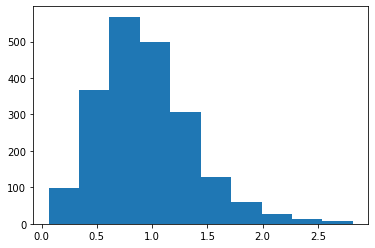

In [10]:
kappa = f2x/tcr - f2x/ecs
# kappa = efficacy * eta
pl.hist(kappa)

In [11]:
lambda0 = geoff_sample_df['lamg'].values
efficacy = geoff_sample_df['eff'].values
eta = geoff_sample_df['gamma_2l'].values
dl = ((geoff_sample_df['cdeep'].values * ur("W m**-2 K**-1 yr")) / (DENSITY_WATER * HEAT_CAPACITY_WATER)).to_base_units().magnitude
du = ((geoff_sample_df['cmix'].values * ur("W m**-2 K**-1 yr")) / (DENSITY_WATER * HEAT_CAPACITY_WATER)).to_base_units().magnitude

(array([ 11., 119., 342., 492., 498., 383., 150.,  57.,  20.,   7.]),
 array([0.27307514, 0.37775681, 0.48243849, 0.58712017, 0.69180185,
        0.79648353, 0.90116521, 1.00584689, 1.11052856, 1.21521024,
        1.31989192]),
 <BarContainer object of 10 artists>)

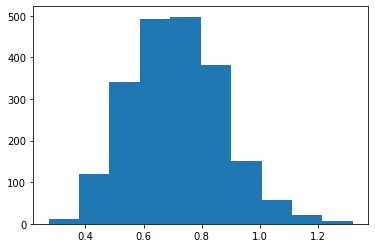

In [12]:
pl.hist(eta)

## Forcing uncertainties - ensure consistency with 040

### Aerosol emissions

In [13]:
ERFari = np.zeros((270, len(accept_inds)))
ERFaci = np.zeros((270, len(accept_inds)))

so2 = emissions_ceds_update.loc[:,'SO2']
bc = emissions_ceds_update.loc[:,'BC']
oc = emissions_ceds_update.loc[:,'OC']
nh3 = emissions_ceds_update.loc[:,'NH3']

for i in tqdm(range(len(accept_inds))):
    ERFari[:, i] = (
        (emissions_ceds_update.loc[:,'SO2']-emissions_ceds_update.loc[1750,'SO2']) * beta_so2[i] * 32/64 +
        (emissions_ceds_update.loc[:,'BC']-emissions_ceds_update.loc[1750,'BC']) * beta_bc[i] +
        (emissions_ceds_update.loc[:,'OC']-emissions_ceds_update.loc[1750,'OC']) * beta_oc[i] +
        (emissions_ceds_update.loc[:,'NH3']-emissions_ceds_update.loc[1750,'NH3']) * beta_nh3[i]
    )
    
    ERFaci[:,i] = ghan([so2, bc+oc], beta[i], aci_coeffs[i,0], aci_coeffs[i,1]) - ghan([so2[1750], bc[1750]+oc[1750]], beta[i], aci_coeffs[i,0], aci_coeffs[i,1])

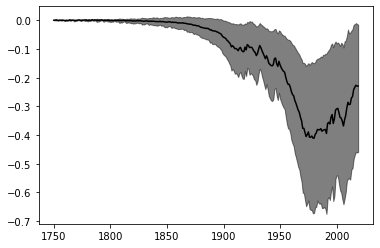

In [14]:
pl.fill_between(np.arange(1750, 2020), np.percentile(ERFari, 5, axis=1), np.percentile(ERFari, 95, axis=1), color='k', alpha=0.5)
pl.plot(np.arange(1750,2020), np.percentile(ERFari, 50, axis=1), color='k')

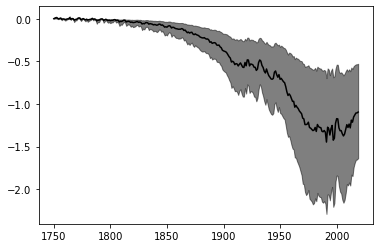

In [15]:
pl.fill_between(np.arange(1750, 2020), np.percentile(ERFaci, 5, axis=1), np.percentile(ERFaci, 95, axis=1), color='k', alpha=0.5)
pl.plot(np.arange(1750,2020), np.percentile(ERFaci, 50, axis=1), color='k')

### Non-aerosol forcings

In [16]:
scale_normals.shape

(2079, 11)

In [17]:
df = pd.read_csv('../data_output/AR6_ERF_1750-2019.csv')
forcing_ensemble = {}
forcing_ensemble['co2'] = df['co2'].values[:,None] * scale_normals[:,0]
forcing_ensemble['ch4'] = df['ch4'].values[:,None] * scale_normals[:,1]
forcing_ensemble['n2o'] = df['n2o'].values[:,None] * scale_normals[:,2]
forcing_ensemble['other_wmghg'] = df['other_wmghg'].values[:,None] * scale_normals[:,3]
forcing_ensemble['o3'] = df['o3'].values[:,None] * scale_normals[:,4]
forcing_ensemble['h2o_stratospheric'] = df['h2o_stratospheric'].values[:,None] * scale_normals[:,5]
forcing_ensemble['contrails'] = df['contrails'].values[:,None] * scale_normals[:,6]
forcing_ensemble['aerosol-radiation_interactions'] = ERFari
forcing_ensemble['aerosol-cloud_interactions'] = ERFaci
forcing_ensemble['bc_on_snow'] = df['bc_on_snow'].values[:,None] * scale_normals[:,7]
forcing_ensemble['land_use'] = df['land_use'].values[:,None] * scale_normals[:,8]
forcing_ensemble['volcanic'] = df['volcanic'].values[:,None] * scale_normals[:,9]
forcing_ensemble['solar'] = np.linspace(0,trend_solar,270) + df['solar'].values[:,None] * scale_normals[:,10]
forcing_ensemble['total'] = (
    forcing_ensemble['co2'] +
    forcing_ensemble['ch4'] +
    forcing_ensemble['n2o'] +
    forcing_ensemble['other_wmghg'] +
    forcing_ensemble['o3'] +
    forcing_ensemble['h2o_stratospheric'] +
    forcing_ensemble['contrails'] +
    forcing_ensemble['aerosol-radiation_interactions'] +
    forcing_ensemble['aerosol-cloud_interactions'] +
    forcing_ensemble['bc_on_snow'] +
    forcing_ensemble['land_use'] +
    forcing_ensemble['volcanic'] +
    forcing_ensemble['solar']
)

In [18]:
forcing_ensemble['total'][:,0].shape

(270,)

# Run climate model

- should use assessed rather than constrained ranges I guess

In [19]:
with open('../data_input/tunings/cmip6_twolayer_tuning_params.json', 'r') as filehandle:
    cmip6_models = json.load(filehandle)
#cmip6_models

In [20]:
#dl = dl.mean()# * ur(cmip6_models['dl']['units'])
#du = du.mean()#  * ur(cmip6_models['du']['units'])
#eta = eta.mean()# * ur(cmip6_models['eta']['units'])
#lambda0 = -4/3# *  ur(cmip6_models['lambda0']['units'])
#efficacy = efficacy.mean()# * ur(cmip6_models['efficacy']['units'])


# for best estimate run do we want to set
ecs = 3.0
tcr = 1.8
f2x = 4.0
lambda0 = f2x/ecs    # sign convention!
kappa = f2x/tcr - f2x/ecs
efficacy = efficacy.mean()
eta = kappa / efficacy
dl = dl.mean()
du = du.mean()

In [21]:
results = {}

In [22]:
du

54.36601154063805

In [23]:
arglist = []
runner = TwoLayerModel()


for i in range(len(accept_inds)):
    arglist.append(
        {
            'in_forcing' : forcing_ensemble['total'][:,i],
            'run_id': i
        }
    )

def run_tlm(args):
    in_forcing = args['in_forcing']
    driver = ScmRun(
        data=in_forcing,#[:,None]*np.ones((270,500)),
        index=np.arange(1750,2020),
        columns={
            "unit": "W/m^2",
            "model": "openscm-twolayermodel-0.2.0",
            "scenario": "historical-AR6",
            "region": "World",
            "variable": "Effective Radiative Forcing",
            "run_id": args['run_id']
        }
    )
    runner.dl = dl*ur(cmip6_models['dl']['units'])
    runner.du = du*ur(cmip6_models['du']['units'])
    runner.eta = eta*ur(cmip6_models['eta']['units'])
    runner.lambda0 = lambda0 * ur(cmip6_models['lambda0']['units'])
    runner.efficacy = efficacy * ur(cmip6_models['efficacy']['units'])
    return (runner.run_scenarios(driver, progress=False))
    
    
if __name__ == '__main__':
    with Pool(16) as pool:
        result = list(tqdm(pool.imap(run_tlm, arglist), total=len(accept_inds)))
    output = run_append(result)

MODEL_TIMESTEP = runner.delta_t.to('s').magnitude
results['AR6-historical'] = {}
results['AR6-historical']['effective_radiative_forcing'] = output.filter(variable='Effective Radiative Forcing').timeseries().values.T
results['AR6-historical']['surface_temperature'] = output.filter(variable='Surface Temperature|Upper').timeseries().values.T


if __name__ == '__main__':
    for agent in tqdm(list(forcing_ensemble.keys())[:-1], desc='Removing one at a time'):
        arglist = []
        for i in range(len(accept_inds)):
            in_forcing = forcing_ensemble['total'][:,i] - forcing_ensemble[agent][:,i]
            arglist.append(
                {
                    'in_forcing' : in_forcing,
                    'run_id': i
                }
            )
        output = []
        results['remove_%s' % agent] = {}
        with Pool(16) as pool:
            result = list(tqdm(pool.imap(run_tlm, arglist), total=len(accept_inds), leave=False))
        output = run_append(result)

        results['remove_%s' % agent]['effective_radiative_forcing'] = output.filter(variable='Effective Radiative Forcing').timeseries().values.T
        results['remove_%s' % agent]['surface_temperature'] = output.filter(variable='Surface Temperature|Upper').timeseries().values.T

In [24]:
arglist = []

lambda0 = -geoff_sample_df['lamg'].values
efficacy = geoff_sample_df['eff'].values
eta = geoff_sample_df['gamma_2l'].values
dl = ((geoff_sample_df['cdeep'].values * ur("W m**-2 K**-1 yr")) / (DENSITY_WATER * HEAT_CAPACITY_WATER)).to_base_units().magnitude
du = ((geoff_sample_df['cmix'].values * ur("W m**-2 K**-1 yr")) / (DENSITY_WATER * HEAT_CAPACITY_WATER)).to_base_units().magnitude

dl = np.array(dl)
du = np.array(du)
eta = np.array(eta)
lambda0 = np.array(lambda0)
efficacy = np.array(efficacy)

for i in range(len(accept_inds)):
    arglist.append(
        {
            'dl': dl[i],
            'du': du[i],
            'eta': eta[i],
            'lambda0': lambda0[i],
            'efficacy': efficacy[i],
            'in_forcing' : forcing_ensemble['total'][:,i],
            'run_id': i
        }
    )

runner = TwoLayerModel()
output = []

results['AR6-historical_climuncert'] = {}

def run_tlm(args):
    in_forcing = args['in_forcing']
    driver = ScmRun(
        data=in_forcing,#[:,None]*np.ones((270,500)),
        index=np.arange(1750,2020),
        columns={
            "unit": "W/m^2",
            "model": "openscm-twolayermodel-0.2.0",
            "scenario": "historical-AR6",
            "region": "World",
            "variable": "Effective Radiative Forcing",
            "run_id": args['run_id']
        }
    )
    runner.dl = args['dl']*ur(cmip6_models['dl']['units'])
    runner.du = args['du']*ur(cmip6_models['du']['units'])
    runner.eta = args['eta']*ur(cmip6_models['eta']['units'])
    runner.lambda0 = args['lambda0'] * ur(cmip6_models['lambda0']['units'])
    runner.efficacy = args['efficacy'] * ur(cmip6_models['efficacy']['units'])
    return (runner.run_scenarios(driver, progress=False))
    
    
if __name__ == '__main__':
    with Pool(16) as pool:
        result = list(tqdm(pool.imap(run_tlm, arglist), total=len(accept_inds)))
    output = run_append(result)

MODEL_TIMESTEP = runner.delta_t.to('s').magnitude
results['AR6-historical_climuncert']['effective_radiative_forcing'] = output.filter(variable='Effective Radiative Forcing').timeseries().values.T
results['AR6-historical_climuncert']['surface_temperature'] = output.filter(variable='Surface Temperature|Upper').timeseries().values.T


if __name__ == '__main__':
    for agent in tqdm(list(forcing_ensemble.keys())[:-1], desc='Removing one at a time'):
        arglist = []
        for i in range(len(accept_inds)):
            in_forcing = forcing_ensemble['total'][:,i] - forcing_ensemble[agent][:,i]
            arglist.append(
                {
                    'in_forcing' : in_forcing,
                    'run_id': i,
                    'dl': dl[i],
                    'du': du[i],
                    'eta': eta[i],
                    'lambda0': lambda0[i],
                    'efficacy': efficacy[i],
                }
            )
        output = []
        results['remove_%s_climuncert' % agent] = {}
        with Pool(16) as pool:
            result = list(tqdm(pool.imap(run_tlm, arglist), total=len(accept_inds), leave=False))
        output = run_append(result)

        results['remove_%s_climuncert' % agent]['effective_radiative_forcing'] = output.filter(variable='Effective Radiative Forcing').timeseries().values.T
        results['remove_%s_climuncert' % agent]['surface_temperature'] = output.filter(variable='Surface Temperature|Upper').timeseries().values.T

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:275: RuntimeWarning: overflow encountered in double_scalars
  uptake_upper = heat_capacity_upper * (t_upper_now - t_upper_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:274: RuntimeWarning: overflow encountered in double_scalars
  uptake_lower = heat_capacity_lower * (t_lower_now - t_lower_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return uptake_upper + uptake_lower
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:253: RuntimeWarning: overflow encountered in double_scalars
  return t_upper + delta_t * dT_dt
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ope

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:275: RuntimeWarning: overflow encountered in double_scalars
  uptake_upper = heat_capacity_upper * (t_upper_now - t_upper_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:274: RuntimeWarning: overflow encountered in double_scalars
  uptake_lower = heat_capacity_lower * (t_lower_now - t_lower_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return uptake_upper + uptake_lower
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:253: RuntimeWarning: overflow encountered in double_scalars
  return t_upper + delta_t * dT_dt
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ope

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:275: RuntimeWarning: overflow encountered in double_scalars
  uptake_upper = heat_capacity_upper * (t_upper_now - t_upper_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:274: RuntimeWarning: overflow encountered in double_scalars
  uptake_lower = heat_capacity_lower * (t_lower_now - t_lower_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return uptake_upper + uptake_lower
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:253: RuntimeWarning: overflow encountered in double_scalars
  return t_upper + delta_t * dT_dt
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ope

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:275: RuntimeWarning: overflow encountered in double_scalars
  uptake_upper = heat_capacity_upper * (t_upper_now - t_upper_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:274: RuntimeWarning: overflow encountered in double_scalars
  uptake_lower = heat_capacity_lower * (t_lower_now - t_lower_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return uptake_upper + uptake_lower
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:253: RuntimeWarning: overflow encountered in double_scalars
  return t_upper + delta_t * dT_dt
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ope

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:275: RuntimeWarning: overflow encountered in double_scalars
  uptake_upper = heat_capacity_upper * (t_upper_now - t_upper_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:274: RuntimeWarning: overflow encountered in double_scalars
  uptake_lower = heat_capacity_lower * (t_lower_now - t_lower_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return uptake_upper + uptake_lower
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:253: RuntimeWarning: overflow encountered in double_scalars
  return t_upper + delta_t * dT_dt
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ope

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:275: RuntimeWarning: overflow encountered in double_scalars
  uptake_upper = heat_capacity_upper * (t_upper_now - t_upper_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:274: RuntimeWarning: overflow encountered in double_scalars
  uptake_lower = heat_capacity_lower * (t_lower_now - t_lower_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return uptake_upper + uptake_lower
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:253: RuntimeWarning: overflow encountered in double_scalars
  return t_upper + delta_t * dT_dt
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ope

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:275: RuntimeWarning: overflow encountered in double_scalars
  uptake_upper = heat_capacity_upper * (t_upper_now - t_upper_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:274: RuntimeWarning: overflow encountered in double_scalars
  uptake_lower = heat_capacity_lower * (t_lower_now - t_lower_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return uptake_upper + uptake_lower
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:253: RuntimeWarning: overflow encountered in double_scalars
  return t_upper + delta_t * dT_dt
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ope

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:275: RuntimeWarning: overflow encountered in double_scalars
  uptake_upper = heat_capacity_upper * (t_upper_now - t_upper_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:274: RuntimeWarning: overflow encountered in double_scalars
  uptake_lower = heat_capacity_lower * (t_lower_now - t_lower_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return uptake_upper + uptake_lower
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:253: RuntimeWarning: overflow encountered in double_scalars
  return t_upper + delta_t * dT_dt
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ope

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:275: RuntimeWarning: overflow encountered in double_scalars
  uptake_upper = heat_capacity_upper * (t_upper_now - t_upper_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:274: RuntimeWarning: overflow encountered in double_scalars
  uptake_lower = heat_capacity_lower * (t_lower_now - t_lower_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return uptake_upper + uptake_lower
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:253: RuntimeWarning: overflow encountered in double_scalars
  return t_upper + delta_t * dT_dt
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ope

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:275: RuntimeWarning: overflow encountered in double_scalars
  uptake_upper = heat_capacity_upper * (t_upper_now - t_upper_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:274: RuntimeWarning: overflow encountered in double_scalars
  uptake_lower = heat_capacity_lower * (t_lower_now - t_lower_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return uptake_upper + uptake_lower
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:253: RuntimeWarning: overflow encountered in double_scalars
  return t_upper + delta_t * dT_dt
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ope

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:275: RuntimeWarning: overflow encountered in double_scalars
  uptake_upper = heat_capacity_upper * (t_upper_now - t_upper_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:274: RuntimeWarning: overflow encountered in double_scalars
  uptake_lower = heat_capacity_lower * (t_lower_now - t_lower_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return uptake_upper + uptake_lower
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:253: RuntimeWarning: overflow encountered in double_scalars
  return t_upper + delta_t * dT_dt
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ope

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:275: RuntimeWarning: overflow encountered in double_scalars
  uptake_upper = heat_capacity_upper * (t_upper_now - t_upper_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:274: RuntimeWarning: overflow encountered in double_scalars
  uptake_lower = heat_capacity_lower * (t_lower_now - t_lower_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return uptake_upper + uptake_lower
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:253: RuntimeWarning: overflow encountered in double_scalars
  return t_upper + delta_t * dT_dt
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ope

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:274: RuntimeWarning: overflow encountered in double_scalars
  uptake_lower = heat_capacity_lower * (t_lower_now - t_lower_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:275: RuntimeWarning: overflow encountered in double_scalars
  uptake_upper = heat_capacity_upper * (t_upper_now - t_upper_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return uptake_upper + uptake_lower
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:253: RuntimeWarning: overflow encountered in double_scalars
  return t_upper + delta_t * dT_dt
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ope

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:274: RuntimeWarning: overflow encountered in double_scalars
  uptake_lower = heat_capacity_lower * (t_lower_now - t_lower_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:275: RuntimeWarning: overflow encountered in double_scalars
  uptake_upper = heat_capacity_upper * (t_upper_now - t_upper_prev) / delta_t
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:277: RuntimeWarning: invalid value encountered in double_scalars
  return uptake_upper + uptake_lower
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/openscm_twolayermodel/two_layer_model.py:253: RuntimeWarning: overflow encountered in double_scalars
  return t_upper + delta_t * dT_dt
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ope

In [25]:
# results = {}
# results['AR6-historical'] = {}
# MODEL_TIMESTEP = runner.delta_t.to('s').magnitude
# results['AR6-historical']['effective_radiative_forcing'] = output.filter(variable='Effective Radiative Forcing').timeseries().values.T
# results['AR6-historical']['surface_temperature'] = output.filter(variable='Surface Temperature|Upper').timeseries().values.T
# results['AR6-historical']['deep_ocean_temperature'] = output.filter(variable='Surface Temperature|Lower').timeseries().values.T
# results['AR6-historical']['net_energy_imbalance'] = output.filter(variable='Heat Uptake').timeseries().values.T
# results['AR6-historical']['ocean_heat_content'] = (
#     np.cumsum(results['historical-AR6']['net_energy_imbalance'], axis=0) * 4 * np.pi * EARTH_RADIUS**2 * MODEL_TIMESTEP
# )
# results['AR6-historical']['ECS'] = ecs
# results['AR6-historical']['TCR'] = tcr
# results['AR6-historical']['lambda0'] = lambda0
# results['AR6-historical']['eta'] = eta
# results['AR6-historical']['efficacy'] = efficacy
# results['AR6-historical']['dl'] = dl
# results['AR6-historical']['du'] = du

# #save_dict_to_hdf5(results, '../data_output_large/twolayer_AR6-historical.h5')

In [26]:
# results['historical-AR6']['ECS']

In [27]:
# if __name__ == '__main__':
#     for agent in tqdm(list(forcing_ensemble.keys())[:-1], desc='Removing one at a time'):
#         arglist = []
#         for i in range(SAMPLES):
#             in_forcing = forcing_ensemble['total'][:,i] - forcing_ensemble[agent][:,i]
#             arglist.append(
#                 {
#                     'in_forcing' : in_forcing,
#                     'run_id': i
#                 }
#             )
#         output = []
#         results['remove_%s' % agent] = {}
#         with Pool(16) as pool:
#             result = list(tqdm(pool.imap(run_tlm, arglist), total=SAMPLES, leave=False))
#         output = run_append(result)

#         results['remove_%s' % agent]['effective_radiative_forcing'] = output.filter(variable='Effective Radiative Forcing').timeseries().values.T
#         results['remove_%s' % agent]['surface_temperature'] = output.filter(variable='Surface Temperature|Upper').timeseries().values.T

In [28]:
# runner = TwoLayerModel()
# output = []

# results['AR6-historical_climuncert'] = {}

# def run_tlm(args):
#     in_forcing = args['in_forcing']
#     driver = ScmRun(
#         data=in_forcing,#[:,None]*np.ones((270,500)),
#         index=np.arange(1750,2020),
#         columns={
#             "unit": "W/m^2",
#             "model": "openscm-twolayermodel-0.2.0",
#             "scenario": "historical-AR6",
#             "region": "World",
#             "variable": "Effective Radiative Forcing",
#             "run_id": args['run_id']
#         }
#     )
#     runner.dl = args['dl']*ur(cmip6_models['dl']['units'])
#     runner.du = args['du']*ur(cmip6_models['du']['units'])
#     runner.eta = args['eta']*ur(cmip6_models['eta']['units'])
#     runner.lambda0 = args['lambda0'] * ur(cmip6_models['lambda0']['units'])
#     runner.efficacy = args['efficacy'] * ur(cmip6_models['efficacy']['units'])
#     return (runner.run_scenarios(driver, progress=False))
    
    
# if __name__ == '__main__':
#     with Pool(16) as pool:
#         result = list(tqdm(pool.imap(run_tlm, arglist), total=SAMPLES))
#     output = run_append(result)

# MODEL_TIMESTEP = runner.delta_t.to('s').magnitude
# results['AR6-historical_climuncert']['effective_radiative_forcing'] = output.filter(variable='Effective Radiative Forcing').timeseries().values.T
# results['AR6-historical_climuncert']['surface_temperature'] = output.filter(variable='Surface Temperature|Upper').timeseries().values.T


# if __name__ == '__main__':
#     for agent in tqdm(list(forcing_ensemble.keys())[:-1], desc='Removing one at a time'):
#         arglist = []
#         for i in range(SAMPLES):
#             in_forcing = forcing_ensemble['total'][:,i] - forcing_ensemble[agent][:,i]
#             arglist.append(
#                 {
#                     'in_forcing' : in_forcing,
#                     'run_id': i,
#                     'dl': dl[i],
#                     'du': du[i],
#                     'eta': eta[i],
#                     'lambda0': lambda0[i],
#                     'efficacy': efficacy[i],
#                 }
#             )
#         output = []
#         results['remove_%s_climuncert' % agent] = {}
#         with Pool(16) as pool:
#             result = list(tqdm(pool.imap(run_tlm, arglist), total=SAMPLES, leave=False))
#         output = run_append(result)

#         results['remove_%s_climuncert' % agent]['effective_radiative_forcing'] = output.filter(variable='Effective Radiative Forcing').timeseries().values.T
#         results['remove_%s_climuncert' % agent]['surface_temperature'] = output.filter(variable='Surface Temperature|Upper').timeseries().values.T

In [29]:
save_dict_to_hdf5(results, '../data_output_large/twolayer_AR6-historical.h5')